# AutoEncoder

Building an Autoencoder roughly based on the U-Net.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import datetime

## Data Preprocessing

I will start by loading two of the images in. Then I will select from the originals each only one. Aftwards, I will select the 500 images in good and bad quality from the two image and create the classification label for it.

In [2]:
select = np.random.choice(np.arange(0, 4055), size = 1000)

In [3]:
X_1 = np.load('/home/cloud/MRT_Data/unziped/out/P2_X.npy')

In [4]:
X = X_1

In [5]:
X = X.reshape([4055, 256, 256, 1])

In [6]:
X = X[select, :, :]

In [7]:
del X_1

In [8]:
gc.collect()

14

 Normalize data

In [9]:
Y_1 = np.load('/home/cloud/MRT_Data/unziped/out/P2_Y.npy')

In [10]:
Y = Y_1

In [11]:
Y = Y.reshape([4055, 256, 256, 1])

In [12]:
Y.shape

(4055, 256, 256, 1)

In [13]:
Y = Y[select, :, :]

clean up the mess

In [14]:
gc.collect()

3

In [15]:
Y.shape

(1000, 256, 256, 1)

# Create train and test and validation set

How much of the data should be used for training?

In [16]:
train_frac = 0.9

In [17]:
train_index = int(train_frac * Y.shape[0])

In [18]:
X_train = X[0:train_index,:,:,:]
X_eval = X[train_index:X.shape[0],:,:,:]

In [19]:
Y_train = Y[0:train_index,:,:]
Y_eval = Y[train_index:X.shape[0],:,:,:]

In [20]:
def conv_2(tensor_in, name_layer, n_filter):
    x = tf.layers.conv2d(
        inputs = tensor_in,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_1")
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_2")
    
    return x

In [38]:
def level_up(tensor_in, insert_layer, name_layer, n_filter):
    #print("Shape before level up: " + str(tensor_in.shape))
    x = tf.layers.conv2d_transpose(
            tensor_in,
            filters=n_filter,
            kernel_size=2,
            strides=2,
            padding = 'same',
            name=name_layer + "_upconv")
    #print("Shape after level up: " + str(x.shape))
    
    x = tf.concat([insert_layer, x], axis=-1, name=name_layer + "_insert")
    #print("Shape after putting in other vector: " + str(x.shape))
    
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_1")
    #print("Shape after first conv in level up: " + str(x.shape))
    
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_2")
    #print("Shape after second conv in level up: " + str(x.shape))
    
    return x

# Create and train CNN

In [45]:
def AutoEncoder_model(features, labels, mode):
    
    ## Hyper paramters ##
    eps_start = 0.001 #learning rate in the beginning
    eps_end = 0.0005 #final learning rate
    tau = 40000 # number of iterations afterwards is the learning rate constant
    #####################
    
    is_training_mode = (mode == tf.estimator.ModeKeys.TRAIN)
    
    # Input Tensor
    input_tensor = features['x']
    
    # Level 0
    level_0 = conv_2(input_tensor, "level_0", n_filter = 64)
    level_0_pool = tf.layers.max_pooling2d(level_0, (2, 2), strides=(2, 2), name="level_0_pooling")
    
    # Level 1
    level_1 = conv_2(level_0_pool, "level_1", n_filter = 128)
    level_1_pool = tf.layers.max_pooling2d(level_1, (2, 2), strides=(2, 2), name="level_1_pooling")
    
    # Level 2
    level_2 = conv_2(level_1_pool, "level_2", n_filter = 256)
    level_2_pool = tf.layers.max_pooling2d(level_2, (2, 2), strides=(2, 2), name="level_2_pooling")
    
    # Level 3
    level_3 = conv_2(level_2_pool, "level_3", n_filter = 512)
    level_3_pool = tf.layers.max_pooling2d(level_3, (2, 2), strides=(2, 2), name="level_3_pooling")
    
    # Level 4
    level_4 = conv_2(level_3_pool, "level_4", n_filter = 1024)
    
    # Level 3
    level_3_up = level_up(level_4,level_3,"level_3_up" , n_filter = 512)
    
    # Level 2
    level_2_up = level_up(level_3_up,level_2, "level_2_up" , n_filter = 256)
    
    # Level 1
    level_1_up = level_up(level_2_up,level_1, "level_1_up" , n_filter = 128)
    
    # Level 0
    level_0_up = level_up(level_1_up,level_0,"level_0_up"  , n_filter = 64)
    
        # final 
    final_layer = tf.layers.conv2d(
        inputs = level_0_up,
        filters = 1,
        kernel_size = [1, 1],
        padding = "same",
        activation = None,
        name = "final_layer")
    
    # Give output in prediction mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions=final_layer)
    
    # Output all learnable variables for tensorboard
    for var in tf.trainable_variables():
        name = var.name
        name = name.replace(':', '_')
        tf.summary.histogram(name, var)
    merged_summary = tf.summary.merge_all()
    
    # Calculate Loss (for both Train and EVAL modes)
    # See that the residual learning is implemented here.
    loss = tf.losses.mean_squared_error(labels = labels , predictions = final_layer)
    tf.summary.scalar("Value_Loss_Function", loss)
        
    # Configure the Training OP (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        # calculate current learning rate:
        alpha = tf.train.get_global_step() / tau
        cur_learning_rate = tf.maximum(tf.constant(0.0, dtype ='float64'),(1-alpha)) * eps_start + tf.minimum(tf.constant(1.0, dtype ='float64') , alpha) * eps_end
        tf.summary.scalar("Learning_rate", cur_learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(loss = loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

Load train and test data

Create the estimator

In [46]:
runconf = tf.estimator.RunConfig(save_summary_steps=5, log_step_count_steps = 1)

In [47]:
save_dir = "/tmp/AutoEncoder/" + str(datetime.datetime.now())[0:19].replace("-", "_").replace(" ", "_").replace(":", "_").replace(".", "_")

In [48]:
AutoEncoder = tf.estimator.Estimator(config=runconf,
    model_fn=AutoEncoder_model, model_dir=save_dir
    )

INFO:tensorflow:Using config: {'_model_dir': '/tmp/AutoEncoder/2018_12_05_22_17_28', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5423552748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Set up logging for predictions

Train the model

In [49]:
train = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=Y_train,
    batch_size=12,
    num_epochs=None,
    shuffle=True)

In [60]:
AutoEncoder.train(
    input_fn=train,
    steps=20)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/AutoEncoder/2018_12_05_22_17_28/model.ckpt-3
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3 into /tmp/AutoEncoder/2018_12_05_22_17_28/model.ckpt.
INFO:tensorflow:loss = 0.004277601, step = 4
INFO:tensorflow:global_step/sec: 0.0146004
INFO:tensorflow:loss = 0.017484017, step = 5 (68.492 sec)
INFO:tensorflow:global_step/sec: 0.0150337
INFO:tensorflow:loss = 0.010702993, step = 6 (66.518 sec)
INFO:tensorflow:global_step/sec: 0.0149771
INFO:tensorflow:loss = 0.016816244, step = 7 (66.767 sec)
INFO:tensorflow:global_step/sec: 0.0150588
INFO:tensorflow:loss = 0.027835427, step = 8 (66.408 sec)
INFO:tensorflow:global_step/sec: 0.0147716
INFO:tensorflow:loss = 0.008608479, step = 9 (67.709 sec)
INFO:tensorflow:global_ste

KeyboardInterrupt: 

## Evaluate the model

Make predictions

This is what we train for (our label)

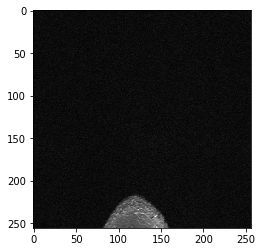

This is the input of the NN (The noisy image)

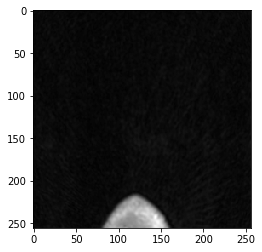

This is the true image, can be calculated as the difference of X to the label we train on

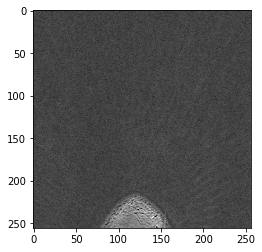

In [53]:
plt.imshow(X_eval[1,:,:,0] , cmap='gray' )

This is an original image. What does our network predict?

In [61]:
# Evaluate the model and print results
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_eval[1:2,:,:,:]},
    y=X_eval[1:2,:,:,:],
    num_epochs=1,
    shuffle=False)
predict_results = AutoEncoder.predict(input_fn=predict_input_fn)
predict_results = list(predict_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/AutoEncoder/2018_12_05_22_17_28/model.ckpt-12
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


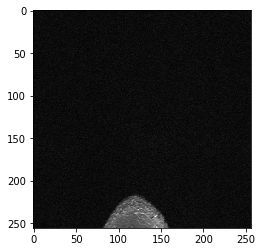

In [62]:
plt.imshow(Y_eval[1,:,:,0], cmap='gray' )

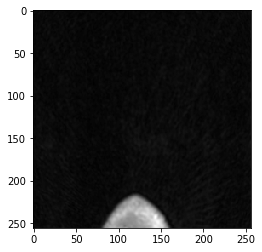

In [63]:
plt.imshow(X_eval[1,:,:,0], cmap='gray' )

The first dictionary is the image shown above. Although I cannot see much in the picture the network is 99.8% sure that it is original!

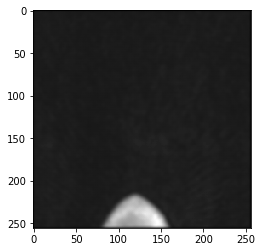

In [64]:
plt.imshow(predict_results[0][:,:,0], cmap='gray')

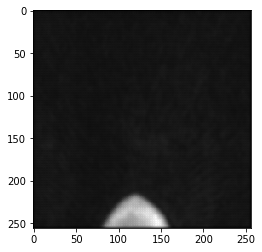

In [55]:
plt.imshow(predict_results[0][:,:,0], cmap='gray')